# Parameter Learning and Structure Learning

Replicated from [pgmpy_notebook/10. Learning Bayesian Networks from Data.ipynb at master · pgmpy/pgmpy_notebook · GitHub](https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/10.%20Learning%20Bayesian%20Networks%20from%20Data.ipynb)

**Parameter learning:** Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.
 
**Structure learning:** Given a set of data samples, estimate a DAG that captures the dependencies between the variables.
 
This notebook aims to illustrate how parameter learning and structure learning can be done with pgmpy.
Currently, the library supports:
 - Parameter learning for *discrete* nodes:
   - Maximum Likelihood Estimation
   - Bayesian Estimation
 - Structure learning for *discrete*, *fully observed* networks:
   - Score-based structure estimation (BIC/BDeu/K2 score; exhaustive search, hill climb/tabu search)
   - Constraint-based structure estimation (PC)
   - Hybrid structure estimation (MMHC)

## Parameter Learning

In [9]:
import sys
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator,BayesianEstimator, ExpectationMaximization

sys.path.append('../scripts')
from utils import *

In [3]:
df_fruits = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
df_fruits

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large
3,apple,yes,small
4,banana,yes,large
5,apple,yes,large
6,banana,yes,large
7,apple,yes,small
8,apple,yes,large
9,apple,yes,large


In [4]:
model_fruits = BayesianModel([('fruit', 'tasty'), ('size', 'tasty')])

/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


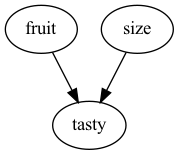

In [5]:
ASSETS_FOLDER = '../assets/'
display_bayesian_model(model_fruits, ASSETS_FOLDER+ 'fruits_network.png')

Parameter learning is the task to <mark>estimate the values of the conditional probability distributions (CPDs)</mark>, for the variables `fruit`, `size`, and `tasty`. 

## State counts
To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e. for seperately for each parent configuration:

In [7]:
pe = ParameterEstimator(model_fruits, df_fruits)
pe.state_counts('fruit')

,fruit
apple,7
banana,7


In [8]:
pe.state_counts('tasty')

fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0

Maximum Likelihood Estimation (MLE):

MLE assumes that each variable follows a specific distribution, such as a categorical or multinomial distribution. We will estimate the parameters by counting the occurrences of each variable combination in the dataset and normalizing to obtain probabilities.

In [10]:
mle = MaximumLikelihoodEstimator(model_fruits, df_fruits)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


Bayesian Estimation:

Bayesian estimation <mark>incorporates prior knowledge or beliefs about the parameters</mark>.


Dirichlet Prior:

The Dirichlet prior is a commonly used prior distribution in Bayesian estimation. It assumes a symmetric Dirichlet distribution, where all the states of a variable are equally likely a priori. The Dirichlet prior is simple and tends to encourage a uniform distribution over the possible states of the variable. It is often used when there is limited prior knowledge about the variable.

BDeu Prior:

The BDeu (Bayesian Dirichlet equivalent uniform) prior is a smoothing technique that assigns a prior that is proportional to the number of possible instantiations of the parents' states. It avoids excessive concentration of probability mass in the parameter estimation process. BDeu prior is useful when the sample size is small, and there is little prior knowledge about the distribution.

K2 Prior:

The K2 prior assumes a uniform distribution over the possible instantiations of the parents' states. It is a more relaxed prior compared to the Dirichlet and BDeu priors and can be useful when there is little prior knowledge and the sample size is larger.

In [20]:
bayesian_estimator = BayesianEstimator(model_fruits, df_fruits)
bayesian_parameters = bayesian_estimator.estimate_cpd(
    'tasty',
    prior_type='BDeu'
)

print(bayesian_parameters)

+------------+---------------------+-----+--------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)      |
+------------+---------------------+-----+--------------------+
| size       | size(large)         | ... | size(small)        |
+------------+---------------------+-----+--------------------+
| tasty(no)  | 0.30952380952380953 | ... | 0.7222222222222222 |
+------------+---------------------+-----+--------------------+
| tasty(yes) | 0.6904761904761905  | ... | 0.2777777777777778 |
+------------+---------------------+-----+--------------------+


The EM algorithm can be used for parameter learning when dealing with missing or incomplete data. In this case, we will assume complete data.

In [25]:
complete_data = df_fruits.copy()

em_estimator = ParameterEstimator(model_fruits, complete_data)
em_parameters = em_estimator.state_counts('tasty')

print(em_parameters)

fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


In [27]:
# Calibrate all CPDs of `model` using MLE:
model_fruits.fit(df_fruits, estimator=MaximumLikelihoodEstimator)


While very straightforward, the <mark>ML estimator has the problem of *overfitting*</marl> to the data. In above CPD, the probability of a large banana being tasty is estimated at `0.833`, because `5` out of `6` observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at `0.0`, because we  observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren't tasty!
We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off. 

When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for `10^3 = 1000` parents configurations. <mark>This makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE's overfitting is *Bayesian Parameter Estimation*.<mark>

#### Bayesian Parameter Estimation

The <mark>Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables *before* the data was observed. Those "priors" are then updated, using the state counts from the observed data.</mark> See [1], Section 17.3 for a general introduction to Bayesian estimators.

One can think of the priors as consisting in *pseudo state counts*, that are added to the actual counts before normalization.
Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called *K2* prior, which simply adds `1` to the count of every single state.
A somewhat more sensible choice of prior is *BDeu* (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an *equivalent sample size* `N` and then the pseudo-counts are the equivalent of having observed `N` uniform samples of each variable (and each parent configuration). In pgmpy:




In [30]:
est = BayesianEstimator(model_fruits, df_fruits)

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

+------------+---------------------+-----+---------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)       |
+------------+---------------------+-----+---------------------+
| size       | size(large)         | ... | size(small)         |
+------------+---------------------+-----+---------------------+
| tasty(no)  | 0.34615384615384615 | ... | 0.6428571428571429  |
+------------+---------------------+-----+---------------------+
| tasty(yes) | 0.6538461538461539  | ... | 0.35714285714285715 |
+------------+---------------------+-----+---------------------+


The estimated values in the CPDs are now more conservative. In particular, the estimate for a small banana being not tasty is now around `0.64` rather than `1.0`. Setting `equivalent_sample_size` to `10` means that for each parent configuration, we add the equivalent of 10 uniform samples (here: `+5` small bananas that are tasty and `+5` that aren't).

`BayesianEstimator`, too, can be used via the `fit()`-method.

## Structure Learning

To learn model structure (a DAG) from a data set, there are two broad techniques:

 - score-based structure learning
 - constraint-based structure learning

The combination of both techniques allows further improvement:
 - hybrid structure learning

We briefly discuss all approaches and give examples.

### Score-based Structure Learning


This approach construes model selection as an optimization task. It has two building blocks:

- A _scoring function_ $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$.
- A _search strategy_ to traverse the search space of possible models $M$ and select a model with optimal score.


#### Scoring functions

Commonly used scores to measure the fit between model and data are _Bayesian Dirichlet scores_ such as *BDeu* or *K2* and the _Bayesian Information Criterion_ (BIC, also called MDL). See [1], Section 18.3 for a detailed introduction on scores. <mark>As before, BDeu is dependent on an equivalent sample size.</mark>

In [34]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianModel([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianModel([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z

print(bdeu.score(model1))
print(k2.score(model1))
print(bic.score(model1))

print(bdeu.score(model2))
print(k2.score(model2))
print(bic.score(model2))


/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


<IPython.core.display.Image object>
<IPython.core.display.Image object>
-13939.778431142335
-14330.614630879747
-14295.816964955355
-20906.012774711624
-20932.841229021953
-20950.05422784874


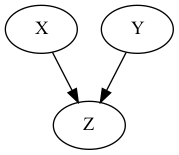

In [36]:
display_bayesian_model(model1, ASSETS_FOLDER+'sl-model1.png')

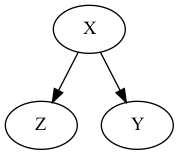

In [35]:
display_bayesian_model(model2, ASSETS_FOLDER+'sl-model2.png')

While the scores vary slightly, we can see that the correct `model1` has a much higher score than `model2`.
Importantly, these scores _decompose_, i.e. they can be computed locally for each of the variables given their potential parents, independent of other parts of the network:

In [37]:
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

-9205.860163060448
-6993.4433973257
-57.12148149574858


#### Search strategies
<mark>The search space of DAGs is super-exponential in the number of variables</mark> and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, the second prohibits efficient local optimization algorithms to always find the optimal structure. Thus, identifiying the ideal structure is often not tractable. Despite these bad news, heuristic search strategies often yields good results.

<mark>If only few nodes are involved (read: less than 5), `ExhaustiveSearch` can be used to compute the score for every DAG and returns the best-scoring one:</mark>

In [40]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14295.816964955355 [('X', 'Z'), ('Y', 'Z')]
-14329.827602077276 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14329.827602077276 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14329.827602077276 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14329.827602077276 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-14329.827602077277 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14329.827602077277 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-16510.513850211606 [('X', 'Y'), ('Z', 'Y')]
-16511.398363822278 [('Y', 'X'), ('Z', 'X')]
-18734.472828981816 [('Z', 'X'), ('Z', 'Y')]
-18734.47282898182 [('Y', 'Z'), ('Z', 'X')]
-18734.47282898182 [('X', 'Z'), ('Z', 'Y')]
-20915.159077116143 [('Z', 'Y')]
-20915.15907711615 [('Y', 'Z')]
-20916.04359072682 [('Z', 'X')]
-20916.04359072682 [('X', 'Z')]
-20949.169714238065 [('Y', 'X'), ('Z', 'Y')]
-20949.16971423807 [('Y', 'Z'), ('Y', 'X')]
-20949.16971423807 [('X', 'Y'), ('Y', 'Z')]
-20950.054227848737 [('X', 'Y'), ('X', 'Z')]
-20950.05422784874 [('X', 'Z'), ('Y', 

<mark>Once more nodes are involved, one needs to switch to heuristic search. </mark>`HillClimbSearch` implements a greedy local search that starts from the DAG `start` (default: disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.




In [41]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|                                                                            | 5/1000000 [00:00<9:00:54, 30.81it/s]

[('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H')]


In [43]:
# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 4)), columns=list('ABCD'))
data['C'] += data['A'] - data['B']
data['D'] -= data['C']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())

  0%|                                                                            | 3/1000000 [00:00<3:17:31, 84.37it/s]

[('A', 'C'), ('B', 'C'), ('C', 'D')]


The search correctly identifies e.g. that `B` and `C` do not influnce `H` directly, only through `A` and of course that `D`, `E`, `F` are independent.


To enforce a wider exploration of the search space, the search can be enhanced with a tabu list. The list keeps track of the last `n` modfications; those are then not allowed to be reversed, regardless of the score. <mark>Additionally a `white_list` or `black_list` can be supplied to restrict the search to a particular subset or to exclude certain edges.</mark> The parameter `max_indegree` allows to restrict the maximum number of parents for each node.


### Constraint-based Structure Learning

A different, but quite straightforward approach to build a DAG from data is this:

1. Identify independencies in the data set using hypothesis tests 
2. Construct DAG (pattern) according to identified independencies

#### (Conditional) Independence Tests

Independencies in the data can be identified using chi2 conditional independence tests. To this end, a conditional independence hypothesis test is performed to check if `X` is independent from `Y` given a set of variables `Zs`:

In [44]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

print(chi_square(X='B', Y='H', Z=[], data=data, significance_level=0.05))          # dependent
print(chi_square(X='B', Y='E', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='B', Y='H', Z=['A'], data=data, significance_level=0.05))       # independent
print(chi_square(X='A', Y='G', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='A', Y='G', Z=['H'], data=data, significance_level=0.05))       # dependent

False
True
True
True
False


/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):


#### DAG (pattern) construction

With a method for independence testing at hand, we can construct a DAG from the data set in three steps:
1. Construct an undirected skeleton - `estimate_skeleton()`
2. Orient compelled edges to obtain partially directed acyclid graph (PDAG; I-equivalence class of DAGs) - `skeleton_to_pdag()`
3. Extend DAG pattern to a DAG by conservatively orienting the remaining edges in some way - `pdag_to_dag()`

Step 1.&2. form the so-called PC algorithm, see [2], page 550. PDAGs are `DirectedGraph`s, that may contain both-way edges, to indicate that the orientation for the edge is not determined.




In [46]:
est = PC(data)
skel, seperating_sets = est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = pdag.to_dag()
print("DAG edges:        ", model.edges())

Working for n conditional variables: 1:  20%|████████▊                                   | 1/5 [00:00<00:00, 24.64it/s]/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pa

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H'), ('F', 'E'), ('E', 'F')]
DAG edges:         [('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H'), ('F', 'E')]


The `estimate()`-method provides a shorthand for the three steps above and directly returns a `BayesianModel`:

In [47]:
print(est.estimate(significance_level=0.01).edges())

Working for n conditional variables: 1:  20%|████████▊                                   | 1/5 [00:00<00:00, 25.16it/s]/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pa

[('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H'), ('F', 'E')]


PC PDAG construction is only guaranteed to work under the assumption that the identified set of independencies is *faithful*, i.e. there exists a DAG that exactly corresponds to it. Spurious dependencies in the data set can cause the reported independencies to violate faithfulness. It can happen that the estimated PDAG does not have any faithful completions (i.e. edge orientations that do not introduce new v-structures). In that case a warning is issued.


### Hybrid Structure Learning

The MMHC algorithm [3] combines the constraint-based and score-based method. It has two parts:

1. Learn undirected graph skeleton using the constraint-based construction procedure MMPC
2. Orient edges using score-based optimization (BDeu score + modified hill-climbing)

We can perform the two steps seperately, more or less as follows:

In [49]:
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

mmhc = MmhcEstimator(data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(data))
print("Part 2) Model:    ", model.edges())

/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
/opt/homebrew/Caskroom/miniconda/base/envs/pgm/lib/python3.10/site-packages/pgmpy/estimators/CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't

Part 1) Skeleton:  [('A', 'C'), ('A', 'B'), ('A', 'H'), ('A', 'F'), ('B', 'C'), ('D', 'G'), ('E', 'F'), ('E', 'H'), ('F', 'H'), ('F', 'G'), ('G', 'H')]


  0%|                                                                           | 6/1000000 [00:00<1:49:58, 151.54it/s]

Part 2) Model:     [('A', 'H'), ('A', 'B'), ('A', 'C'), ('C', 'B'), ('F', 'E'), ('G', 'H')]


### References

[1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009

[2] Neapolitan, [Learning Bayesian Networks](http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks&#40;Neapolitan,%20Richard&#41;.pdf), 2003

[3] Tsamardinos et al., [The max-min hill-climbing BN structure learning algorithm](http://www.dsl-lab.org/supplements/mmhc_paper/paper_online.pdf), 2005
